In [3]:
import tensorflow as tf

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")


Default GPU Device: /device:GPU:0


# MNIST

* Entropia Global das Imagens (Entropia Aplicada Diretamente flatten)



# Apartir daqui aplicamos entropia no filtro de validação também (o v09) não executa essa ação.

## Criação e definição de todas as funções

1.   Filtro de Entropia
2.   Carregamento, Preprocesssamento e Tratamento
3.   Criação do Modelo
4.   Predições Estatisticas
5.   Plot de Acuracy e Loss

In [10]:
from keras.datasets import mnist
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
#from keras.src.utils.np_utils import to_categorical
from keras.utils import to_categorical
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import time

def filtrar_entropia_median(train_X, train_y):  # filtro de entropia
    base = 2 # base de logaritimo
    tuplasEntropia = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(train_X)] #operacao de flaten sob base para calcular entropia e enumerar
    entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
    n = len(entropiesLocal_ordenado)
    if n % 2 == 1:
        median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
    else:
        median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
    indices_filtrados = [item[0] for item in entropiesLocal_ordenado if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    train_y = np.array([train_y[i] for i in indices_filtrados]) # passa os indices selecionados para base de labels
    return train_X, train_y

def carregarPeparar(train_X, train_y, test_X, test_y, d, c): # Carregamento e Tratamento
  train_X = train_X.reshape((train_X.shape[0], d, d, c))   # Ajuste da dimensão
  test_X = test_X.reshape((test_X.shape[0], d, d, c))    # Ajuste da dimensão
  train_X = train_X.astype("float")/255.0     # Normalização
  test_X = test_X.astype("float")/255.0     # Normalização
  train_y = to_categorical(train_y, 10) #10 classes possiveis   -   # to Categorical para as classes
  test_y = to_categorical(test_y, 10) #10 classes possiveis     -   # to Categorical para as classes
  return train_X, train_y, test_X, test_y

def avaliacao_statistica(test_X, test_y):
    predictions = model.predict(test_X) # Previsões
    classePredita = np.argmax(predictions, axis=1)
    classeVerdadeira = np.argmax(test_y, axis=1)
    cm = confusion_matrix(classeVerdadeira, classePredita)
    ConfusionMatrixDisplay(cm).plot()  # classePredita para matrix de confusao
    acc = accuracy_score(classeVerdadeira, classePredita) * 100  # Acuracia
    print("Acuracia: ", '%.3f' % (acc*1.0))
    sens = recall_score(classeVerdadeira, classePredita, average='macro')  # Sensibilidade
    print("Sensibilidade: ", '%.3f' % (sens*1.0))

def plotAcuraciaLoss(history): #plots
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro gráfico  # Primeiro gráfico (accuracy)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo gráfico # Segundo gráfico (loss)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.tight_layout() # Exibir os gráficos

def plotarDadosTrain(index_inicio, qtd, train_X): # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
  base = 330
  import matplotlib.pyplot as plt
  for i in range(index_inicio, index_inicio + qtd):
      plt.subplot(base + 1 + (i - index_inicio))
      plt.imshow(train_X[i], cmap=plt.get_cmap('gray'))
  plt.show()
  print(train_y[index_inicio:index_inicio + qtd])

def tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF = None): # x = time.time() || inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
  elapsed_time = [["Carregar DataSet", 0], ["Filtro Entropia", 0], ["Pre-processamento", 0], ["Criação do Modelo", 0], ["Treinamento", 0], ["Inicio à Fim Execução" , 0]]
  elapsed_time[0][1] = importacaoF - inicio  # tempo de inicio de execução até o final da importação do dataset
  if (entropiaF != None): elapsed_time[1][1] = entropiaF - importacaoF  # Tempo gasto Inicio é importaçãoF - Execução da Entropia
  elapsed_time[2][1] = padrozinacaoF - importacaoF  # pega o tempo da entropia e subtrai do tempo apos a padronização para verificar quanto tempo padronizacao demorou
  elapsed_time[3][1] = criacaoModeloF - padrozinacaoF  # tempo da padronizacao - tempo apos a criacao do modelo para verificar tempo decorido
  elapsed_time[4][1] = treinamentoF - criacaoModeloF  # tempo inicial é marcado pela criacaoModeloF - tempoTreinamento que marca o momento que treinamento terminou
  elapsed_time[5][1] = treinamentoF - inicio #tempo total de execução inicio| importações até final da Execução | treinamento
  for index, tempo in enumerate(elapsed_time):
    if entropiaF is None and index == 1:
      continue
    print("{}: {:.4f}".format(tempo[0], round(tempo[1], 2)) + str(" em milissegundos"))

### [MNIST]Treinamento e ordem de execução das funções
  * **[Modelo da CNN para MNIST]**

In [11]:
def criacaoModeloF1(): # Criação do Modelo
  model = Sequential()
  model.add(Conv2D(32, (3,3), activation = 'relu', kernel_initializer = 'he_uniform', input_shape = (28, 28, 1)))
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(Dropout(0.4))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D((2, 2)))

  model.add(Flatten())
  model.add(Dense(128, activation = 'relu', kernel_initializer = 'he_uniform'))
  model.add(Dropout(0.5))
  model.add(Dense(10, activation = 'softmax'))  # classificação 10 categorias

  opt = SGD(learning_rate=0.01, momentum =0.9) #copilaçãoModelo
  model.compile(optimizer=opt, loss = 'categorical_crossentropy', metrics= ['accuracy'])
  return model

### [MNIST]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Completo]**

Epoch 1/10
1875/1875 [==============================] - 48s 16ms/step - loss: 0.3661 - accuracy: 0.8845 - val_loss: 0.0547 - val_accuracy: 0.9840
Epoch 2/10
1875/1875 [==============================] - 26s 14ms/step - loss: 0.1446 - accuracy: 0.9584 - val_loss: 0.0462 - val_accuracy: 0.9875
Epoch 3/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0944 - accuracy: 0.9731 - val_loss: 0.0366 - val_accuracy: 0.9897
Epoch 4/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0767 - accuracy: 0.9786 - val_loss: 0.0589 - val_accuracy: 0.9870
Epoch 5/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0660 - accuracy: 0.9818 - val_loss: 0.0309 - val_accuracy: 0.9924
Epoch 6/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0511 - accuracy: 0.9858 - val_loss: 0.0351 - val_accuracy: 0.9916
Epoch 7/10
1875/1875 [==============================] - 22s 12ms/step - loss: 0.0470 - accuracy: 0.9868 - val_loss: 0.0283 -

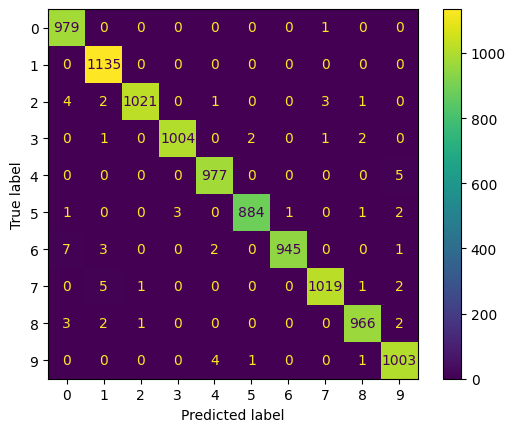

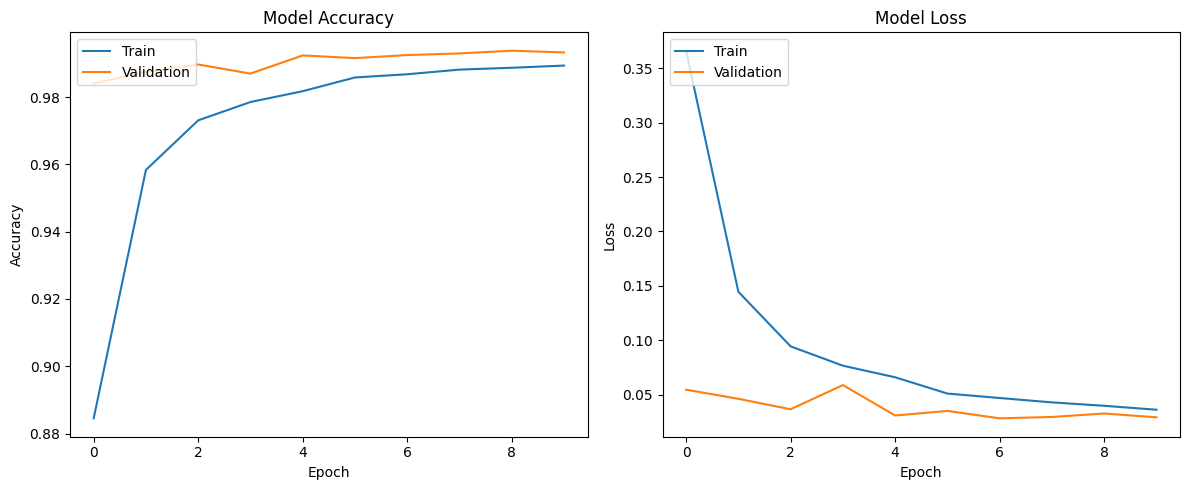

In [12]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### [MNIST]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Divido na metade e aletatorio]**

Epoch 1/10
938/938 [==============================] - 14s 13ms/step - loss: 2.3170 - accuracy: 0.1067 - val_loss: 2.3013 - val_accuracy: 0.1067
Epoch 2/10
938/938 [==============================] - 14s 15ms/step - loss: 2.3022 - accuracy: 0.1092 - val_loss: 2.3033 - val_accuracy: 0.0953
Epoch 3/10
938/938 [==============================] - 13s 14ms/step - loss: 2.3023 - accuracy: 0.1090 - val_loss: 2.3030 - val_accuracy: 0.1036
Epoch 4/10
938/938 [==============================] - 13s 14ms/step - loss: 2.3023 - accuracy: 0.1086 - val_loss: 2.3020 - val_accuracy: 0.1120
Epoch 5/10
938/938 [==============================] - 13s 14ms/step - loss: 2.3023 - accuracy: 0.1112 - val_loss: 2.3017 - val_accuracy: 0.1002
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 2.3022 - accuracy: 0.1085 - val_loss: 2.3009 - val_accuracy: 0.1125
Epoch 7/10
938/938 [==============================] - 13s 13ms/step - loss: 2.3021 - accuracy: 0.1104 - val_loss: 2.3017 - val_accuracy:

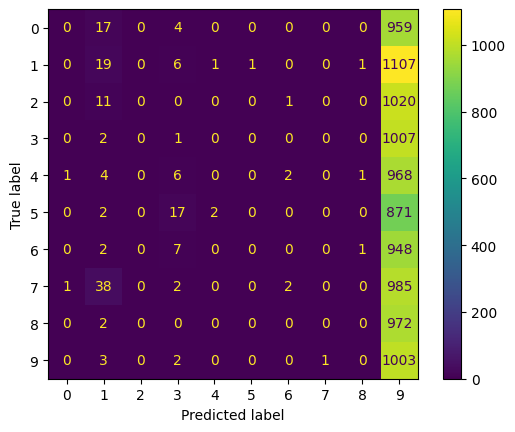

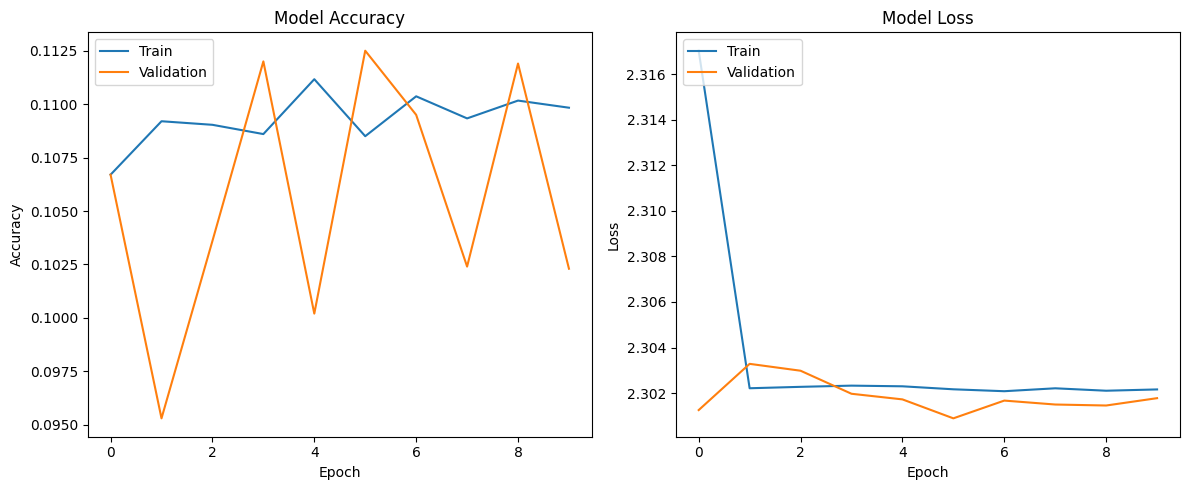

In [13]:
from sklearn.model_selection import train_test_split
import random
def selecionar_metade_aleatoria(metade1, metade2):
    return metade1 if random.choice([True, False]) else metade2

inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
metade_train_X, outra_metade_train_X, metade_train_y, outra_metade_train_y = train_test_split(train_X, train_y, test_size=0.5, random_state=42) # Corte aleatorio do dataset na metade
train_X = selecionar_metade_aleatoria(metade_train_X, outra_metade_train_X)
train_y = selecionar_metade_aleatoria(metade_train_y, outra_metade_train_y)

importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### [MNIST]Treinamento e ordem de execução das funções
 * **[Modelo selecionado com entropia]**
 * **Baixa Entropia**

## Filtro de entropia :
  * Dataset filtrado

Epoch 1/10
938/938 [==============================] - 14s 14ms/step - loss: 0.4433 - accuracy: 0.8636 - val_loss: 0.1366 - val_accuracy: 0.9564
Epoch 2/10
938/938 [==============================] - 13s 13ms/step - loss: 0.1934 - accuracy: 0.9447 - val_loss: 0.1191 - val_accuracy: 0.9679
Epoch 3/10
938/938 [==============================] - 12s 13ms/step - loss: 0.1416 - accuracy: 0.9596 - val_loss: 0.0600 - val_accuracy: 0.9832
Epoch 4/10
938/938 [==============================] - 12s 12ms/step - loss: 0.1208 - accuracy: 0.9659 - val_loss: 0.0619 - val_accuracy: 0.9820
Epoch 5/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0918 - accuracy: 0.9737 - val_loss: 0.0647 - val_accuracy: 0.9820
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0832 - accuracy: 0.9757 - val_loss: 0.0513 - val_accuracy: 0.9853
Epoch 7/10
938/938 [==============================] - 12s 12ms/step - loss: 0.0723 - accuracy: 0.9801 - val_loss: 0.0558 - val_accuracy:

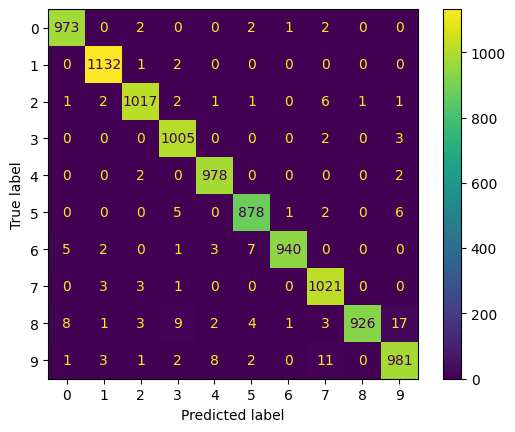

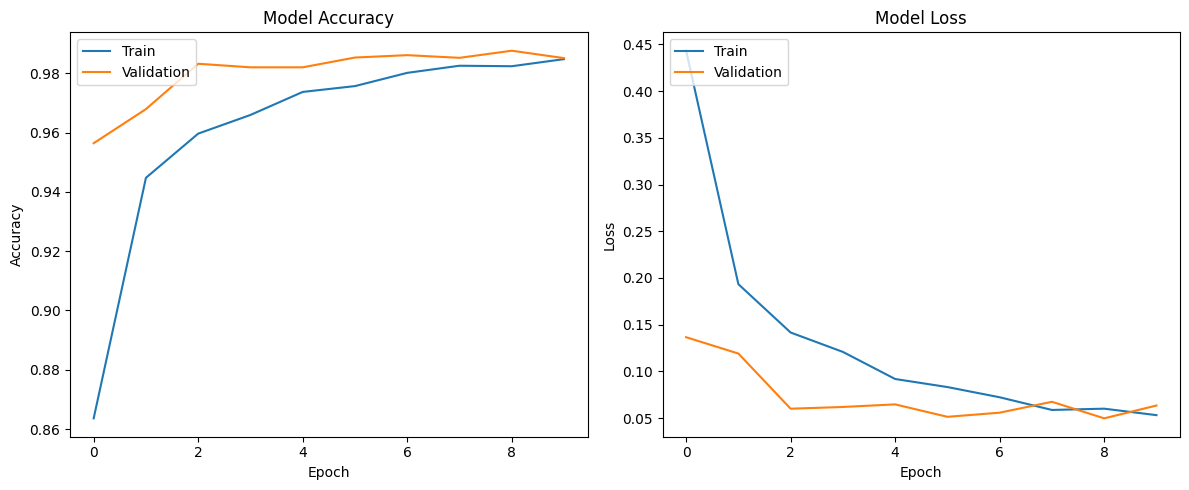

In [14]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados de treino
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

## Filtro de entropia utilizando resubstituição:
  * Dataset filtrado e o dataset passado para validação

Epoch 1/10
938/938 [==============================] - 17s 17ms/step - loss: 0.4391 - accuracy: 0.8655 - val_loss: 0.1329 - val_accuracy: 0.9640
Epoch 2/10
938/938 [==============================] - 15s 16ms/step - loss: 0.1966 - accuracy: 0.9426 - val_loss: 0.0758 - val_accuracy: 0.9765
Epoch 3/10
938/938 [==============================] - 17s 18ms/step - loss: 0.1410 - accuracy: 0.9608 - val_loss: 0.0573 - val_accuracy: 0.9837
Epoch 4/10
938/938 [==============================] - 16s 17ms/step - loss: 0.1081 - accuracy: 0.9700 - val_loss: 0.0464 - val_accuracy: 0.9880
Epoch 5/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0954 - accuracy: 0.9738 - val_loss: 0.0298 - val_accuracy: 0.9922
Epoch 6/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0791 - accuracy: 0.9775 - val_loss: 0.0347 - val_accuracy: 0.9900
Epoch 7/10
938/938 [==============================] - 15s 16ms/step - loss: 0.0699 - accuracy: 0.9803 - val_loss: 0.0288 - val_accuracy:

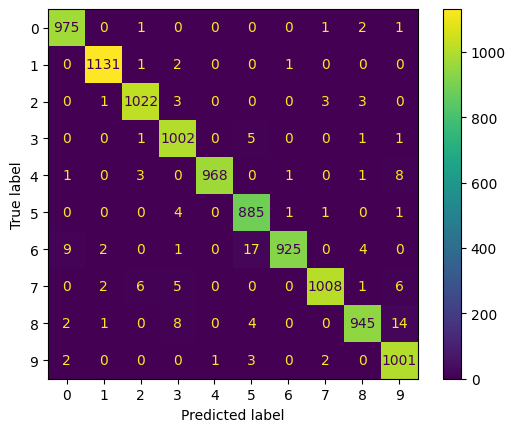

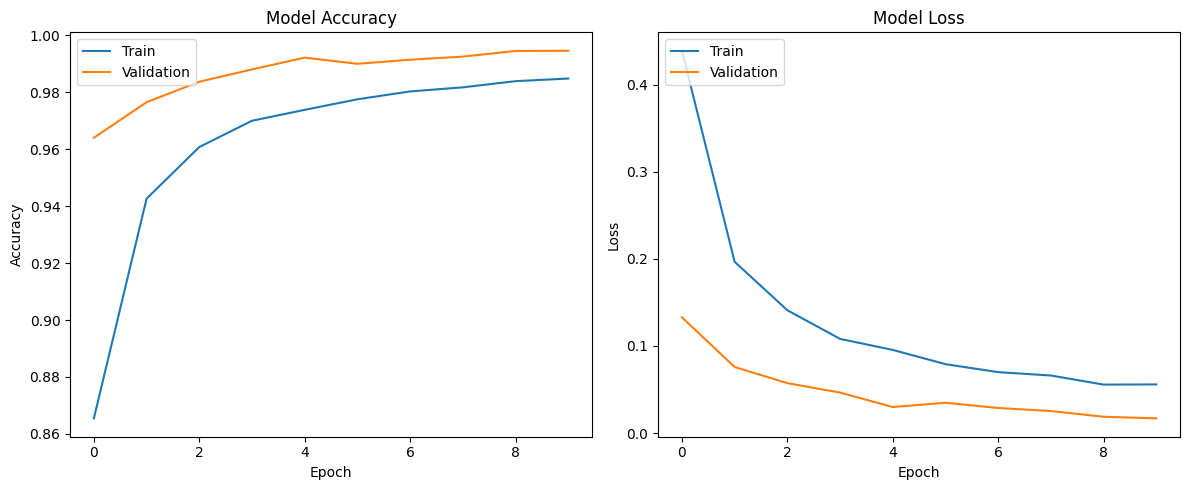

In [17]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados de treino
#test_X, test_y = filtrar_entropia_median_validation(test_X, test_y)  #filtro de entropia sob conjunto de dados de validação
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(train_X, train_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

## Filtro de entropia utilizando filtro no dataset e no conjunto de validação:
  * Dataset filtrado e o filtrando o conjunto de dados de validação

Epoch 1/10
938/938 [==============================] - 13s 13ms/step - loss: 0.5008 - accuracy: 0.8422 - val_loss: 0.1022 - val_accuracy: 0.9692
Epoch 2/10
938/938 [==============================] - 10s 11ms/step - loss: 0.2108 - accuracy: 0.9385 - val_loss: 0.0588 - val_accuracy: 0.9836
Epoch 3/10
938/938 [==============================] - 10s 11ms/step - loss: 0.1407 - accuracy: 0.9590 - val_loss: 0.0513 - val_accuracy: 0.9872
Epoch 4/10
938/938 [==============================] - 11s 12ms/step - loss: 0.1115 - accuracy: 0.9681 - val_loss: 0.0468 - val_accuracy: 0.9866
Epoch 5/10
938/938 [==============================] - 11s 11ms/step - loss: 0.1027 - accuracy: 0.9708 - val_loss: 0.0495 - val_accuracy: 0.9870
Epoch 6/10
938/938 [==============================] - 12s 13ms/step - loss: 0.0879 - accuracy: 0.9749 - val_loss: 0.0376 - val_accuracy: 0.9896
Epoch 7/10
938/938 [==============================] - 11s 12ms/step - loss: 0.0819 - accuracy: 0.9759 - val_loss: 0.0358 - val_accuracy:

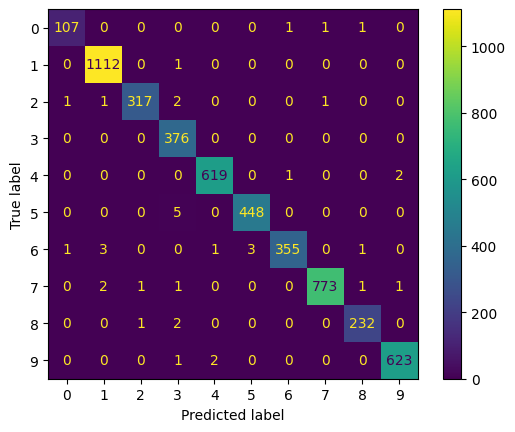

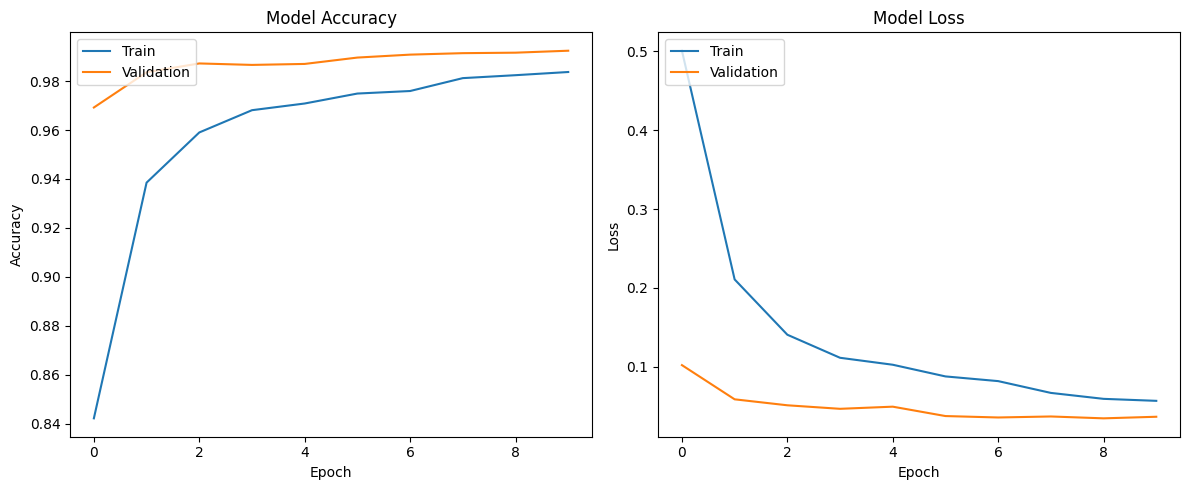

In [18]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados de treino
test_X, test_y = filtrar_entropia_median(test_X, test_y)  #filtro de entropia sob conjunto de dados de validação
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 10, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

# Importando Dados CIFAR-10

* Entropia Global das Imagens (Entropia Aplicada Diretamente flatten)

## Criação e definição de todas as funções

1.   Filtro de Entropia
2.   Carregamento, Preprocesssamento e Tratamento
3.   Criação do Modelo [mesmo modelo do MNIST]
4.   Predições Estatisticas
5.   Plot de Acuracy e Loss

### [CIFAR]Treinamento e ordem de execução das funções
 * **[Modelo selecionado sem entropia]**

In [ ]:
from keras import regularizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
def criacaoModeloG8(x_train):
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))

  initial_learning_rate = 0.001
  lr_schedule = ExponentialDecay(
      initial_learning_rate,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)

  opt = SGD(learning_rate=lr_schedule, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [ ]:
from keras.datasets import cifar10
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X) # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 50, batch_size = 128, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

In [ ]:
tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

  ### [CIFAR]Treinamento e ordem de execução das funções
  * **[Sem seleção de entropia]**
  * **[Dataset Divido na metade e aletatorio]**

In [ ]:
from sklearn.model_selection import train_test_split
from keras.datasets import cifar10
import random
def selecionar_metade_aleatoria(metade1, metade2):
    return metade1 if random.choice([True, False]) else metade2

inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
metade_train_X, outra_metade_train_X, metade_train_y, outra_metade_train_y = train_test_split(train_X, train_y, test_size=0.5, random_state=42) # Corte aleatorio do dataset na metade
train_X = selecionar_metade_aleatoria(metade_train_X, outra_metade_train_X)
train_y = selecionar_metade_aleatoria(metade_train_y, outra_metade_train_y)

importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X)
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 50, batch_size = 128, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### [CIFAR]Treinamento e ordem de execução das funções
 * **[Modelo selecionado com entropia]**
 * **[Baixa entropia]**

In [ ]:
from keras.datasets import cifar10
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X) # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 50, batch_size = 128, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### [CIFAR]Treinamento e ordem de execução das funções
 * **[Modelo selecionado com entropia]**
 * **[Alta entropia]**

In [ ]:
def filtrar_entropia_medianCifar10MaiorEntropia(train_X, train_y):  # filtro de entropia
    base = 2 # base de logaritimo
    tuplasEntropia = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(train_X)] #operacao de flaten sob base para calcular entropia e enumerar
    entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
    n = len(entropiesLocal_ordenado)
    if n % 2 == 1:
        median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
    else:
        median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
    indices_filtrados = [item[0] for item in entropiesLocal_ordenado if item[1] >= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    train_y = np.array([train_y[i] for i in indices_filtrados]) # passa os indices selecionados para base de labels
    return train_X, train_y

from keras.datasets import cifar10
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = cifar10.load_data() # Carregar o conjunto de dados # Importar e Treinar
importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_medianCifar10MaiorEntropia(train_X, train_y)  #filtro de entropia sob conjunto de dados
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 32, 3) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao
model = criacaoModeloG8(train_X) # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 50, batch_size = 128, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final

tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
#plotarDadosTrain(3000, 9, train_X) # Exemplo: apartir do indice N, exibe K imagens do conjunto de dados, D
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

# Tabela de Resultados

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Dataset': ['MNist Filtro ', 'MNist /s Filtro', 'MNist 1/2', 'Cifar Filtro', 'Cifar s/ Filtro', 'Cifar 1/2', 'Cifar Filtro', 'Cifar /s Filtro', 'Cifar 1/2'],
    'CNN': ['[DeepB]', '[DeepB]', '[DeepB]',  '[DeepB]','[DeepB]','[DeepB]',        '[DeepC]', '[DeepC]', '[DeepC]'],
    'Acurácia': [97.82, 98.86, 10.45,        59.57,65.13,61.15,                    79.13, 86.24, 82.70],
    #'Variação': ['1.0%', '1.0%', '1.0%',      '1.0%','1.0%','1.0%',                  '1.0%', '1.0%', '1,0%'],
    'Sensibilidade': [9.78, 9.88, 0.92,       5.96,6.51,6.12,                       7.91, 8.62, 8.27],
    'Treino(s)': [42.49, 53.96, 32.58,       77.89,139.35,77.07,                   159.52, 298.26, 166.67],
    'entropia (s)' : [1.99, 'Não', 'Não',    4.68,'Não','Não',                     4.86, 'Não', 'Não']
}
df = pd.DataFrame(data)

#seleção de linhas
df_subset = df.iloc[0:10]
fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')
ax.table(cellText=df_subset.values, colLabels=df_subset.columns, cellLoc = 'center', loc='center')
plt.title("Tabela de Dados")
plt.show()

# dataset do mit
# suficiente    media ? mediana
# forma de ficar no quartil com maxima menor entropia (? curvatura do raio),
# indice de gine cria uma margem de escala entre 0 e 1
# conseguir plot de um histograma de entropia entre a distribuição (%)
# conjunto de dataset do google : https://datasetsearch.research.google.com/
# datasets diferentes com propriedades (entropia) semelhantes

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Dataset': ['MNist Filtro ', 'MNist /s Filtro', 'MNist 1/2', 'Cifar Filtro', 'Cifar s/ Filtro', 'Cifar 1/2', 'Cifar Filtro', 'Cifar /s Filtro', 'Cifar 1/2'],
    'CNN': ['[DeepB]', '[DeepB]', '[DeepB]',  '[DeepB]','[DeepB]','[DeepB]',        '[DeepC]', '[DeepC]', '[DeepC]'],
    'Acurácia': [97.82, 98.86, 10.45,        59.57,65.13,61.15,                    79.13, 86.24, 82.70],
    #'Variação': ['1.0%', '1.0%', '1.0%',      '1.0%','1.0%','1.0%',                  '1.0%', '1.0%', '1,0%'],
    'Sensibilidade': [9.78, 9.88, 0.92,       5.96,6.51,6.12,                       7.91, 8.62, 8.27],
    'Treino(s)': [42.49, 53.96, 32.58,       77.89,139.35,77.07,                   159.52, 298.26, 166.67],
    'entropia (s)' : [1.99, 'Não', 'Não',    4.68,'Não','Não',                     4.86, 'Não', 'Não']
}
df = pd.DataFrame(data)

#seleção de linhas
df_subset = df.iloc[0:10]
fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')
ax.table(cellText=df_subset.values, colLabels=df_subset.columns, cellLoc = 'center', loc='center')
plt.title("Tabela de Dados")
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Dataset': ['MNist /s Filtro ', 'MNist Aleatorio', 'MNist Filtro',                    'Cifar /s Filtro ', 'Cifar Aleatorio', 'Cifar Filtro',          ],
    'CNN': ['[DeepF1]', '[DeepF1]', '[DeepF1]',                                           '[DeepG8]','[DeepG8]','[DeepG8]',                               ],
    'Acurácia': [99.38, 11.00, 99.00,                                                     82.08,10.18,73.83,                                              ],
    'Sensibilidade': [0.994, 0.097, 0.99,                                                 0.821,0.102,0.738,                                              ],
    'Epocas': [20, 20, 20,                                                                50,50,50,                                                       ],
    'Taxa': [0.01, 0.01, 0.01,                                                            0.001,0.001,0.001,                                              ],
    'Decaimento Aprendizagem': [0, 0, 0,                                                  0.96,0.96,0.96,                                                 ],
    'Regularizacao pesos': [0, 0, 0,                                                      1e-4,1e-4,1e-4,                                                 ],
    'Data Size': ["60 mil", "30 mil", "30 mil",                                           "50 mil","25 mil","25 mil",                                     ],
    'Treino(s)': [153.08, 90.52, 94.19,                                                   178.11,82.13,80.97,                                             ],
    'entropia (s)' : ["Não","Não",1.97,                                                   "Não","Não",4.7,                                                ]
}
df = pd.DataFrame(data)

#seleção de linhas
df_subset = df.iloc[0:10]
fig, ax = plt.subplots(figsize=(30, 2))
ax.axis('off')
ax.table(cellText=df_subset.values, colLabels=df_subset.columns, cellLoc = 'center', loc='center')
plt.title("Tabela de Dados")
plt.show()

In [ ]:
df.to_excel("tabela_dados.xlsx", index=False, engine='openpyxl')

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    'Dataset': ['MNist /s Filtro ', 'MNist Aleatorio', 'MNist Filtro',          'MNist /s Filtro ', 'MNist Aleatorio', 'MNist Filtro',         ],
    'CNN': ['[DeepF1]', '[DeepF1]', '[DeepF1]',                                 '[DeepG8]','[DeepG8]','[DeepG8]'                                ],
    'Acurácia': [0, 0, 0,                                                                 0,0,0,                                                ],
    'Epocas': [0, 0, 0,                                                                   0,0,0,                                                ],
    'Sensibilidade': [0, 0, 0,                                                            0,0,0,                                                ],
    'Treino(s)': [0, 0, 0,                                                                0,0,0,                                                ],
    'entropia (s)' : [ 0,0,0,                                                             0,0,0,                                                ]
}
df = pd.DataFrame(data)

#seleção de linhas
df_subset = df.iloc[0:10]
fig, ax = plt.subplots(figsize=(20, 4))
ax.axis('off')
ax.table(cellText=df_subset.values, colLabels=df_subset.columns, cellLoc = 'center', loc='center')
plt.title("Tabela de Dados")
plt.show()

# Analise calculo da entropia da Biblioteca vs Calculo (criado)

In [ ]:
#Analise os resultados dos valores da entropia em relação a formula (Biblioteca vs calculo)

(train_x5, train_y5), (test_x5, test_y5) = mnist.load_data() #Pegar o dataset
base = 10 # base de logaritimo
pk = np.array(train_x5[3].flatten())
H = entropy(pk, base=base)
print(H)
pk2 = np.array(train_x5[3])
H2 = entropy(pk, base=base)
print(H2)

def entropia(pk, base=10):
    pk = pk / np.sum(pk)
    pk = pk[pk > 0]
    return -np.sum(pk * np.log(pk) / np.log(base))

# estrutura de dados multidimensional (como uma matriz)
(train_x5, train_y5), (test_x5, test_y5) = mnist.load_data() #Pegar o dataset
tuplasEntropia1 = [(index, entropia(img.flatten())) for index, img in enumerate(train_x5)]
print(tuplasEntropia1[3])

# uma estrutura unidimensional (como um vetor).
(train_x5, train_y5), (test_x5, test_y5) = mnist.load_data() #Pegar o dataset
tuplasEntropia2 = [(index, entropia(img)) for index, img in enumerate(train_x5)]
print(tuplasEntropia2[3])

print("Invalirante se multidimensional (como uma matriz) == estrutura unidimensional (como um vetor).")

# MNIST
1. Objetivo analisar as transformações para achatamento antes e depois da aplicação de entropia assim como, transformação da escala e redução de dimensão.



In [ ]:
from keras.datasets import mnist
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from keras.src.utils.np_utils import to_categorical
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from PIL import Image
import time

def filtrar_entropia_median(train_X, train_y):  # filtro de entropia
    base = 2 # base de logaritimo
    tuplasEntropia = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(train_X)] #operacao de flaten sob base para calcular entropia e enumerar
    entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
    n = len(entropiesLocal_ordenado)
    if n % 2 == 1:
        median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
    else:
        median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
    indices_filtrados = [item[0] for item in entropiesLocal_ordenado if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    train_y = np.array([train_y[i] for i in indices_filtrados]) # passa os indices selecionados para base de labels
    return train_X, train_y

def carregarPeparar(train_X, train_y, test_X, test_y, d, c): # Carregamento e Tratamento
  train_X = train_X.reshape((train_X.shape[0], d, d, c))   # Ajuste da dimensão
  test_X = test_X.reshape((test_X.shape[0], d, d, c))    # Ajuste da dimensão
  train_X = train_X.astype("float")/255.0       # Normalização
  test_X = test_X.astype("float")/255.0         # Normalização
  train_y = to_categorical(train_y, 10)         #10 classes possiveis   -   # to Categorical para as classes
  test_y = to_categorical(test_y, 10)           #10 classes possiveis     -   # to Categorical para as classes
  return train_X, train_y, test_X, test_y

import tensorflow as tf
from tensorflow.image import flip_left_right
from tensorflow.image import flip_up_down
import matplotlib.pyplot as plt

def flip(img, direcao = 'horizontal'):
  train_x3 = img.reshape((img.shape[0], 28, 28, 1))   # Ajuste da dimensão
  if (direcao == 'horizontal'):
    train_x3_flip = [tf.image.flip_left_right(img) for img in train_x3]
    #plt.imshow(train_x3_flip[0], cmap='gray')
    #plt.show()
    #plt.imshow(train_x3[0], cmap='gray')
    #plt.show()
    return tf.stack(train_x3_flip, axis=0).numpy()
  elif (direcao == 'vertical'):
    train_x3_flip = [flip_up_down(img) for img in train_x3]
    #plt.imshow(train_x3_flip[0], cmap='gray')
    #plt.show()
    #plt.imshow(train_x3[0], cmap='gray')
    #plt.show()
    return tf.stack(train_x3_flip, axis=0).numpy()
  else:
    raise print("Direcao deve ser: (horizontal ou vertical).")

def indicesEntropiaMedian(train_X, train_Y, test_X, test_Y):
  train_X = train_X.reshape((train_X.shape[0], 28, 28, 1))   # Ajuste da dimensão
  test_X = test_X.reshape((test_X.shape[0], 28, 28, 1))    # Ajuste da dimensão
  train_X = train_X.astype("float")/255.0     # Normalização
  test_X = test_X.astype("float")/255.0     # Normalização
  train_Y = to_categorical(train_Y, 10) #10 classes possiveis   -   # to Categorical para as classes
  test_Y = to_categorical(test_Y, 10) #10 classes possiveis     -   # to Categorical para as classes

  tuplasEntropia = [(index, entropia(img.flatten())) for index, img in enumerate(train_X)]
  #print(tuplasEntropia[:10])
  entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
  #print(entropiesLocal_ordenado[:10])
  n = len(entropiesLocal_ordenado)
  if n % 2 == 1:
      median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
  else:
      median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
  indices_filtrados = np.array([item[0] for item in entropiesLocal_ordenado if item[1] <= median])  #selecionando os indices de entropia entropia baixa abaixo da mediana.
  #print(indices_filtrados[:10])
  return indices_filtrados

def analiseConjuntos(conjuntoA, ConjuntoB):
  set1 = set(conjuntoA)
  set2 = set(ConjuntoB)
  elementosComuns = set1.intersection(set2)
  total = len(conjuntoA)
  elComum = len(elementosComuns)
  porcen = round(((elComum/total)*100),2)
  print(f"Total de elementos em comum: {elComum}, porcentagem de elementos em comun: {porcen}%.")

### MNist:
1. Objetivo da Analise (Dimensões, normalização, redução de dimensionalidade)
  * ( Filtro Entropia => Transformação 2D para 1D => Normalização Treinamento)

In [ ]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar

importacaoF = time.time() #tempo de importacao
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
padrozinacaoF = time.time() #tempo de padronizacao

model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 20, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final
tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

### MNist:
1. Objetivo da Analise (Dimensões, normalização, redução de dimensionalidade)
  * (Transformação 2D para 1D => Normalização Treinamento => Filtro Entropia)

In [ ]:
inicio = time.time() #tempo de inicio
(train_X, train_y), (test_X, test_y) = mnist.load_data() # Carregar o conjunto de dados # Importar e Treinar

importacaoF = time.time() #tempo de importacao
train_X, train_y, test_X, test_y = carregarPeparar(train_X, train_y, test_X, test_y, 28, 1) #padronização e categorização
entropiaF = time.time() #tempo de filtragem entropia
train_X, train_y = filtrar_entropia_median(train_X, train_y)  #filtro de entropia sob conjunto de dados
padrozinacaoF = time.time() #tempo de padronizacao

model = criacaoModeloF1() # instanciando o modelo
criacaoModeloF = time.time() #tempo de criacao do modelo
history = model.fit(train_X, train_y, epochs = 20, batch_size = 32, validation_data=(test_X, test_y), verbose = 1) #treinamento
treinamentoF = time.time() #tempo final
tempDecorrido(inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF) #inicio, importacaoF, padrozinacaoF, criacaoModeloF, treinamentoF, entropiaF
avaliacao_statistica(test_X, test_y)
plotAcuraciaLoss(history)

#### PCA [MNist]
1. Objetivo da Analise (Dimensões, normalização, redução de dimensionalidade)
  * (Transformação 2D para 1D => Normalização Treinamento => Filtro Entropia)
  

In [ ]:
from sklearn.decomposition import PCA

(train_x7, train_y7), (test_x7, test_y7) = mnist.load_data() #import
train_x7, train_y7 = filtrar_entropia_median(train_x7, train_y7) #filtrar direto entropia

train_x7 = train_x7.reshape((train_x7.shape[0], 28, 28, 1))   # Ajuste da dimensão
test_x7 = test_x7.reshape((test_x7.shape[0], 28, 28, 1))    # Ajuste da dimensão
train_x7 = train_x7.astype("float")/255.0     # Normalização
test_x7 = test_x7.astype("float")/255.0     # Normalização
train_y7 = to_categorical(train_y7, 10) #10 classes possiveis   -   # to Categorical para as classes
test_y7 = to_categorical(test_y7, 10) #10 classes possiveis     -   # to Categorical para as classes

pca = PCA(0.9)        # PCA
train_x_pca = pca.fit_transform(train_x_2d) # PCA
train_x_reverted = pca.inverse_transform(train_x_pca)
train_x_cnn = train_x_reverted.reshape(-1, 28, 28, 1)

model = criacaoModeloF1() # instanciando o modelo
history = model.fit(train_x7, train_y7, epochs = 20, batch_size = 32, validation_data=(test_x7, test_y7), verbose = 1) #treinamento

avaliacao_statistica(test_x7, test_y7)
plotAcuraciaLoss(history)

#### PCA [MNist]
1. Objetivo da Analise (Dimensões, normalização, redução de dimensionalidade)
  * (Transformação 2D para 1D => Normalização Treinamento => Filtro Entropia)

In [ ]:
from sklearn.decomposition import PCA

(train_x7, train_y7), (test_x7, test_y7) = mnist.load_data() #import
train_x7 = train_x7.reshape((train_x7.shape[0], 28, 28, 1))   # Ajuste da dimensão
test_x7 = test_x7.reshape((test_x7.shape[0], 28, 28, 1))    # Ajuste da dimensão
train_x7 = train_x7.astype("float")/255.0     # Normalização
test_x7 = test_x7.astype("float")/255.0     # Normalização
train_y7 = to_categorical(train_y7, 10) #10 classes possiveis   -   # to Categorical para as classes
test_y7 = to_categorical(test_y7, 10) #10 classes possiveis     -   # to Categorical para as classes

pca = PCA(0.9)        # PCA
train_x_pca = pca.fit_transform(train_x_2d) # PCA
train_x_reverted = pca.inverse_transform(train_x_pca)
train_x_cnn = train_x_reverted.reshape(-1, 28, 28, 1)

train_x7, train_y7 = filtrar_entropia_median(train_x7, train_y7) #filtrar direto entropia

model = criacaoModeloF1() # instanciando o modelo
history = model.fit(train_x7, train_y7, epochs = 20, batch_size = 32, validation_data=(test_x7, test_y7), verbose = 1) #treinamento
avaliacao_statistica(test_x7, test_y7)
plotAcuraciaLoss(history)

#### PCA [Cifar10]
1. Objetivo da Analise (Dimensões, normalização, redução de dimensionalidade)
  * (Transformação 2D para 1D => Normalização Treinamento => Filtro Entropia)

In [ ]:
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from tensorflow.keras.datasets import mnist
from sklearn.decomposition import PCA
from keras.datasets import mnist
import numpy as np
from scipy.stats import entropy
import matplotlib.pyplot as plt
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.models import Sequential
from keras.optimizers import SGD
from sklearn import metrics
from sklearn.metrics import accuracy_score, recall_score
from keras.src.utils.np_utils import to_categorical
from keras.layers import Dropout
from keras.layers import BatchNormalization
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.datasets import cifar10
import time
from keras import regularizers
from keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers.schedules import ExponentialDecay
def criacaoModeloG8(x_train):
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  model.add(Dense(10, activation='softmax'))

  initial_learning_rate = 0.001
  lr_schedule = ExponentialDecay(
      initial_learning_rate,
      decay_steps=100000,
      decay_rate=0.96,
      staircase=True)

  opt = SGD(learning_rate=lr_schedule, momentum=0.9)
  model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
  return model


def avaliacao_statistica(test_X, test_y):
    predictions = model.predict(test_X) # Previsões
    classePredita = np.argmax(predictions, axis=1)
    classeVerdadeira = np.argmax(test_y, axis=1)
    cm = confusion_matrix(classeVerdadeira, classePredita)
    ConfusionMatrixDisplay(cm).plot()  # classePredita para matrix de confusao
    acc = accuracy_score(classeVerdadeira, classePredita) * 100  # Acuracia
    print("Acuracia: ", '%.3f' % (acc*1.0))
    sens = recall_score(classeVerdadeira, classePredita, average='macro')  # Sensibilidade
    print("Sensibilidade: ", '%.3f' % (sens*1.0))

def plotAcuraciaLoss(history): #plots
  plt.figure(figsize=(12, 5))
  plt.subplot(1, 2, 1)  # 1 linha, 2 colunas, primeiro gráfico  # Primeiro gráfico (accuracy)
  plt.plot(history.history['accuracy'])
  plt.plot(history.history['val_accuracy'])
  plt.title('Model Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.subplot(1, 2, 2)  # 1 linha, 2 colunas, segundo gráfico # Segundo gráfico (loss)
  plt.plot(history.history['loss'])
  plt.plot(history.history['val_loss'])
  plt.title('Model Loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.tight_layout() # Exibir os gráficos

def filtrar_entropia_median(train_X, train_y):  # filtro de entropia
    base = 2 # base de logaritimo
    tuplasEntropia = [(index, entropy(img.flatten(), base = base)) for index, img in enumerate(train_X)] #operacao de flaten sob base para calcular entropia e enumerar
    entropiesLocal_ordenado = sorted(tuplasEntropia, key=lambda x: x[1]) #ordenação com base na entropia
    n = len(entropiesLocal_ordenado)
    if n % 2 == 1:
        median = entropiesLocal_ordenado[n // 2][1] # mediana elemento do meio - impares
    else:
        median = (entropiesLocal_ordenado[n // 2 - 1][1] + entropiesLocal_ordenado[n // 2][1]) / 2.0  # mediana elemento do meio-pares
    indices_filtrados = [item[0] for item in entropiesLocal_ordenado if item[1] <= median]  #selecionando os indices de entropia entropia baixa abaixo da mediana.
    train_X = np.array([train_X[i] for i in indices_filtrados]) # passa os indices selecionados para base de treino
    train_y = np.array([train_y[i] for i in indices_filtrados]) # passa os indices selecionados para base de labels
    return train_X, train_y

(train_x8, train_y8), (test_x8, test_y8) = cifar10.load_data() #import
train_x8 = train_x8.reshape((train_x8.shape[0], 32, 32, 3))   # Ajuste da dimensão
test_x8 = test_x8.reshape((test_x8.shape[0], 32, 32, 3))    # Ajuste da dimensão
train_x8 = train_x8.astype("float")/255.0     # Normalização
test_x8 = test_x8.astype("float")/255.0     # Normalização
train_y8 = to_categorical(train_y8, 10) #10 classes possiveis   -   # to Categorical para as classes
test_y8 = to_categorical(test_y8, 10) #10 classes possiveis     -   # to Categorical para as classes

train_x_2d = train_x8.reshape(-1, 32*32)
pca = PCA(0.9)        # PCA
train_x_pca = pca.fit_transform(train_x_2d) # PCA
train_x_reverted = pca.inverse_transform(train_x_pca)
train_x_cnn = train_x_reverted.reshape(-1, 32, 32, 3)

train_x8, train_y8 = filtrar_entropia_median(train_x8, train_y8) #filtrar direto entropia

model = criacaoModeloG8(train_x8)
history = model.fit(train_x8, train_y8, epochs = 50, batch_size = 128, validation_data=(test_x8, test_y8), verbose = 1) #treinamento
avaliacao_statistica(test_x8, test_y8)
plotAcuraciaLoss(history)

In [ ]:
#LBP
